# Tree-Based Modeling

This notebook trains and evaluates four ensemble methods — Random Forest, Gradient Boosting, XGBoost, and LightGBM — on the same feature set used in NB05. The goal is to determine whether non-linear models can meaningfully improve on the R² = 0.263 linear regression baseline established there. All models are evaluated on the same held-out test set (20% of data), and cross-validation is used to confirm generalization before a final GridSearchCV pass on XGBoost.

In [1]:
# imports

# basic df and viz imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn model and metric libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# tree-based models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
# load data
df = pd.read_csv('ExpandedScoresData_Engineered.csv')

# verify engineered features exist
required_cols = ['parent_ed_ordinal', 'study_hours_ordinal', 'avg_score']
assert all(col in df.columns for col in required_cols), "Missing engineered features!"

print(f"Data shape: {df.shape}")
print(f"Target (avg_score) range: {df['avg_score'].min():.1f} - {df['avg_score'].max():.1f}")

Data shape: (30641, 22)
Target (avg_score) range: 9.0 - 100.0


## Feature Selection

The same feature exclusion rules from NB05 apply: individual test scores (`math_score`, `reading_score`, `writing_score`) and `perf_tier` are excluded to prevent target leakage. For this notebook, the ordinal columns (`parent_ed_ordinal`, `study_hours_ordinal`) are also dropped — they encode the same information as their categorical counterparts (`parental_education`, `weekly_study_hours`), which tree models can exploit directly without the ordinal transformation.

In [3]:
# define features — using categorical representations only to avoid redundancy
# (parent_ed_ordinal and study_hours_ordinal encode the same info as their categorical counterparts)
numeric_features = [
    'num_siblings',
    'math_writing_gap',
    'math_reading_gap'
]

categorical_features = [
    'gender',
    'ethnicity',
    'parental_education',
    'lunch_type',
    'test_prep',
    'weekly_study_hours',
    'practice_sports',
    'effort_level'
]

# combine features
feature_cols = categorical_features + numeric_features
X = df[feature_cols]
y = df['avg_score']  # Continuous target

print(f"Features: {len(feature_cols)}")
print(f"Target: avg_score (continuous)")

Features: 11
Target: avg_score (continuous)


## Encoding and Feature Name Sanitization

Categorical features are one-hot encoded using the same `drop='first'` strategy as NB05, eliminating perfect multicollinearity. An additional step sanitizes feature names for XGBoost compatibility: XGBoost prohibits `[`, `]`, and `<` characters in column names (raised as an error during training), so these are replaced with `(`, `)`, and `lt_` respectively before assembling the final DataFrames.

In [4]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# encode categoricals
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

# collect all feature names
encoded_cat_names = encoder.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_names)

# sanitize feature names: XGBoost prohibits [ ] and < in column names
all_feature_names = [
    name.replace('[', '(').replace(']', ')').replace('<', 'lt_').replace('>', 'gt_')
    for name in all_feature_names
]

# combine into DataFrames (preserving feature names for model compatibility)
X_train_final = pd.DataFrame(
    np.hstack([X_train[numeric_features].values, X_train_cat]),
    columns=all_feature_names
)
X_test_final = pd.DataFrame(
    np.hstack([X_test[numeric_features].values, X_test_cat]),
    columns=all_feature_names
)

print(f"Encoded training shape: {X_train_final.shape}")
print(f"Encoded test shape: {X_test_final.shape}")

Encoded training shape: (24512, 26)
Encoded test shape: (6129, 26)


## Model 1 - Random Forest

Random Forest builds an ensemble of independent decision trees, each trained on a random bootstrap sample, and averages their predictions. It is the most interpretable of the four ensemble methods and naturally resists overfitting through the averaging effect. The hyperparameters here prioritize generalization over raw training accuracy: `max_depth=6` limits tree complexity, `min_samples_leaf=10` prevents splits on tiny subgroups, and `max_features='sqrt'` introduces the feature subsampling that gives Random Forest its variance-reducing properties.

In [5]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_final, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_final)
y_test_pred_rf = rf_model.predict(X_test_final)

In [6]:
# evaluate random forest results
print('Random forest results:')
print(f"Train R²: {r2_score(y_train, y_train_pred_rf):.3f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred_rf):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.2f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred_rf):.2f}")

# check for overfitting
train_r2 = r2_score(y_train, y_train_pred_rf)
test_r2 = r2_score(y_test, y_test_pred_rf)
if train_r2 - test_r2 > 0.1:
    print(f"\n⚠️  Overfitting detected: Train R² ({train_r2:.3f}) >> Test R² ({test_r2:.3f})")
else:
    print(f"\n✅ Good generalization: Train-test gap = {train_r2 - test_r2:.3f}")


Random forest results:
Train R²: 0.227
Test R²:  0.221
Test RMSE: 12.67
Test MAE:  10.28

✅ Good generalization: Train-test gap = 0.006


In [7]:
# Random forest feature importance
feature_importance_rf = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Top 15 Features (Random Forest)')
print(feature_importance_rf.head(15))

Top 15 Features (Random Forest)


                                 feature  importance
15                   lunch_type_standard    0.410271
16                        test_prep_none    0.146172
7                      ethnicity_group E    0.102757
13   parental_education_some high school    0.065992
11    parental_education_master's degree    0.047291
3                            gender_male    0.039691
1                       math_writing_gap    0.031660
9   parental_education_bachelor's degree    0.028489
24               effort_level_low_effort    0.026329
25               effort_level_mid_effort    0.017924
2                       math_reading_gap    0.016320
10        parental_education_high school    0.013276
4                      ethnicity_group B    0.011428
6                      ethnicity_group D    0.010472
18              weekly_study_hours_lt_ 5    0.009992


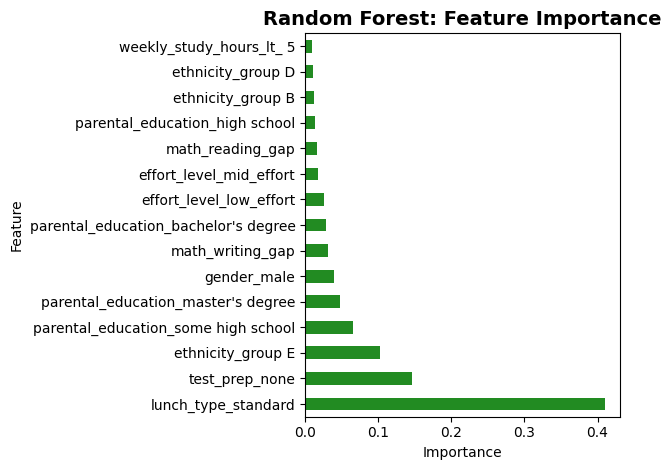

In [8]:
# plot the findings above
feature_importance_rf.head(15).plot(kind='barh', x='feature', y='importance', 
                                     color='forestgreen', legend=False)
plt.title('Random Forest: Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Model 2 - Gradient Boosting

Gradient Boosting builds trees sequentially, with each tree correcting the residuals of the previous ensemble. This sequential error-correction makes it more powerful than Random Forest on tabular data but more sensitive to hyperparameter choices — in particular, tree depth. `max_depth=4` (shallower than Random Forest) is used because boosting steps already contribute incremental corrections; deep individual trees cause each step to overfit the residuals. `subsample=0.8` introduces stochastic sampling per tree, which reduces variance and acts as additional regularization.

In [9]:
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

gb_model.fit(X_train_final, y_train)

# Predictions
y_train_pred_gb = gb_model.predict(X_train_final)
y_test_pred_gb = gb_model.predict(X_test_final)

In [10]:
print('Gradient Boosting Results:')
print(f"Train R²: {r2_score(y_train, y_train_pred_gb):.3f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred_gb):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_gb)):.2f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred_gb):.2f}")

# check for overfitting
train_r2 = r2_score(y_train, y_train_pred_gb)
test_r2 = r2_score(y_test, y_test_pred_gb)
if train_r2 - test_r2 > 0.1:
    print(f"\n⚠️  Overfitting detected: Train R² ({train_r2:.3f}) >> Test R² ({test_r2:.3f})")
else:
    print(f"\n✅ Good generalization: Train-test gap = {train_r2 - test_r2:.3f}")

Gradient Boosting Results:
Train R²: 0.307
Test R²:  0.257
Test RMSE: 12.37
Test MAE:  10.04

✅ Good generalization: Train-test gap = 0.050


## Model 3 - XGBoost

XGBoost is a regularized implementation of gradient boosting with several efficiency and accuracy improvements: second-order gradient approximations, built-in L1/L2 regularization, and parallel tree construction. `max_depth=4` matches Gradient Boosting for consistency — GridSearchCV later validates this is the optimal depth for this dataset. `min_child_weight=3` acts as a minimum number of weighted samples per leaf, providing an additional safeguard against overfitting. `colsample_bytree=0.8` further regularizes by randomly sampling 80% of features per tree.

In [11]:
# train XGBoost

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_final, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_final)
y_test_pred_xgb = xgb_model.predict(X_test_final)

In [12]:
# evaluate XGBoost
print('XGBoost Results:')
print(f"Train R²: {r2_score(y_train, y_train_pred_xgb):.3f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred_xgb):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)):.2f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred_xgb):.2f}")

# check for overfitting
train_r2 = r2_score(y_train, y_train_pred_xgb)
test_r2 = r2_score(y_test, y_test_pred_xgb)
if train_r2 - test_r2 > 0.1:
    print(f"\n⚠️  Overfitting detected: Train R² ({train_r2:.3f}) >> Test R² ({test_r2:.3f})")
else:
    print(f"\n✅ Good generalization: Train-test gap = {train_r2 - test_r2:.3f}")

XGBoost Results:
Train R²: 0.284
Test R²:  0.258
Test RMSE: 12.37
Test MAE:  10.03

✅ Good generalization: Train-test gap = 0.026


In [13]:
# XG Boost feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': all_feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

In [14]:
print('Top 15 Features (XGBoost):')
print(feature_importance_xgb.head(15))

Top 15 Features (XGBoost):
                                 feature  importance
15                   lunch_type_standard    0.337099
16                        test_prep_none    0.111412
7                      ethnicity_group E    0.073768
13   parental_education_some high school    0.055159
9   parental_education_bachelor's degree    0.054441
11    parental_education_master's degree    0.054369
3                            gender_male    0.040643
6                      ethnicity_group D    0.040492
10        parental_education_high school    0.034115
24               effort_level_low_effort    0.022147
25               effort_level_mid_effort    0.020741
17                     test_prep_unknown    0.019885
4                      ethnicity_group B    0.015727
21             practice_sports_regularly    0.015187
19             weekly_study_hours_gt_ 10    0.012780


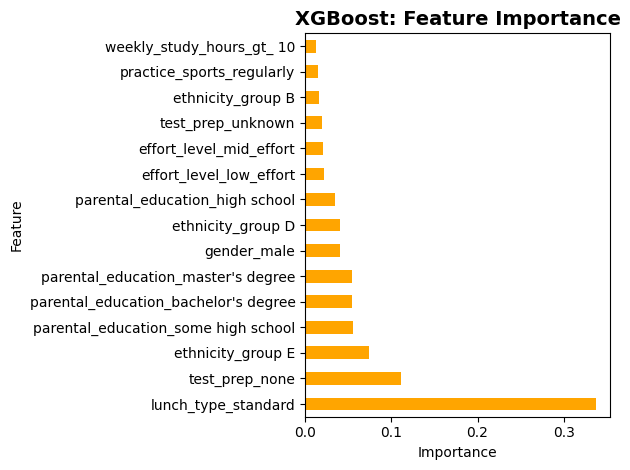

In [15]:
# plot the findings above
feature_importance_xgb.head(15).plot(kind='barh', x='feature', y='importance', 
                                      color='orange', legend=False)
plt.title('XGBoost: Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Model 4 - LightGBM

LightGBM is a highly optimized gradient boosting framework that uses leaf-wise (best-first) tree growth instead of the level-wise approach used by the other models. This makes it faster and often more accurate on large datasets, but also more prone to overfitting without a depth constraint. `max_depth=6` with `num_leaves=31` is the key constraint here: since LightGBM grows leaf-wise, `num_leaves` directly controls tree complexity more precisely than `max_depth` alone — 31 leaves cap the number of leaf nodes, preventing overly complex trees even at depth 6.

In [16]:
# train LightGBM

lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

lgbm_model.fit(X_train_final, y_train)

# Predictions
y_train_pred_lgbm = lgbm_model.predict(X_train_final)
y_test_pred_lgbm = lgbm_model.predict(X_test_final)

In [17]:
# evaluate LightGBM
print('LightGBM Results:')
print(f"Train R²: {r2_score(y_train, y_train_pred_lgbm):.3f}")
print(f"Test R²:  {r2_score(y_test, y_test_pred_lgbm):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_lgbm)):.2f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred_lgbm):.2f}")

# check for overfitting
train_r2 = r2_score(y_train, y_train_pred_lgbm)
test_r2 = r2_score(y_test, y_test_pred_lgbm)
if train_r2 - test_r2 > 0.1:
    print(f"\n⚠️  Overfitting detected: Train R² ({train_r2:.3f}) >> Test R² ({test_r2:.3f})")
else:
    print(f"\n✅ Good generalization: Train-test gap = {train_r2 - test_r2:.3f}")

LightGBM Results:
Train R²: 0.311
Test R²:  0.257
Test RMSE: 12.38
Test MAE:  10.02

✅ Good generalization: Train-test gap = 0.054


In [18]:
# LightGBM feature importance
feature_importance_lgbm = pd.DataFrame({
    'feature': all_feature_names,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Top 15 features (LightGBM):')
print(feature_importance_lgbm.head(15))

Top 15 features (LightGBM):
                                feature  importance
1                      math_writing_gap        1270
2                      math_reading_gap        1165
0                          num_siblings         482
7                     ethnicity_group E         247
3                           gender_male         216
13  parental_education_some high school         200
16                       test_prep_none         186
6                     ethnicity_group D         183
21            practice_sports_regularly         177
15                  lunch_type_standard         168
11   parental_education_master's degree         162
19            weekly_study_hours_gt_ 10         137
10       parental_education_high school         123
4                     ethnicity_group B         120
22            practice_sports_sometimes         112


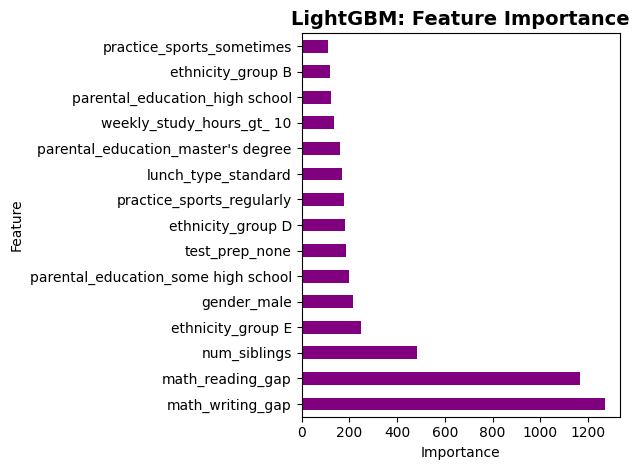

In [19]:
# Plot findings above
feature_importance_lgbm.head(15).plot(kind='barh', x='feature', y='importance', 
                                       color='purple', legend=False)
plt.title('LightGBM: Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Cross-Validation Analysis

Cross-validation provides a more robust estimate of model performance by testing on multiple different train-test splits. This helps ensure our results aren't dependent on a single random split.

In [20]:
print("5-FOLD CROSS-VALIDATION RESULTS")

models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        min_child_samples=20,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
}

# Perform cross-validation on training data only
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_final, y_train,
                             cv=5, scoring='r2', n_jobs=-1)
    cv_results[name] = {
        'mean_r2': scores.mean(),
        'std_r2': scores.std(),
        'scores': scores
    }
    print(f"\n{name}:")
    print(f"  CV R² (mean ± std): {scores.mean():.3f} ± {scores.std():.3f}")
    print(f"  Individual folds: {[f'{s:.3f}' for s in scores]}")

5-FOLD CROSS-VALIDATION RESULTS



Random Forest:
  CV R² (mean ± std): 0.217 ± 0.004
  Individual folds: ['0.215', '0.224', '0.214', '0.215', '0.215']



Gradient Boosting:
  CV R² (mean ± std): 0.252 ± 0.004
  Individual folds: ['0.256', '0.253', '0.253', '0.252', '0.244']



XGBoost:
  CV R² (mean ± std): 0.256 ± 0.005
  Individual folds: ['0.259', '0.261', '0.257', '0.255', '0.247']



LightGBM:
  CV R² (mean ± std): 0.251 ± 0.005
  Individual folds: ['0.255', '0.255', '0.252', '0.251', '0.242']


## Hyperparameter Tuning with GridSearchCV

GridSearchCV allows us to systematically test different hyperparameter combinations to find the optimal configuration. We'll tune XGBoost as an example, since it typically performs best on this type of data.

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
# Define parameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nFitting GridSearchCV (this may take a few minutes)...")
grid_search.fit(X_train_final, y_train)


Fitting GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBRegressor(...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.05, ...], 'max_depth': [4, 6, ...], 'min_child_weight': [1, 3, ...], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and paramet

In [23]:
print('GridSearchCV Results')
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R²: {grid_search.best_score_:.3f}")

GridSearchCV Results
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100}
Best CV R²: 0.256


In [24]:
# Evaluate best model on test set
y_test_pred_tuned = grid_search.best_estimator_.predict(X_test_final)
tuned_test_r2 = r2_score(y_test, y_test_pred_tuned)
tuned_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))

print(f"\nTuned XGBoost Test R²: {tuned_test_r2:.3f}")
print(f"Tuned XGBoost Test RMSE: {tuned_test_rmse:.2f}")
print(f"\nImprovement over default XGBoost: {(tuned_test_r2 - r2_score(y_test, y_test_pred_xgb)):.3f}")


Tuned XGBoost Test R²: 0.258
Tuned XGBoost Test RMSE: 12.37

Improvement over default XGBoost: 0.000


## Comprehensive Model Comparison

In [25]:
print('Comprehensive Model Comparison')

# Compile all results
comparison_data = {
    'Model': [
        'Linear Regression',
        'Random Forest', 
        'Gradient Boosting', 
        'XGBoost',
        'LightGBM',
        'XGBoost (Tuned)'
    ],
    'Test R²': [
        0.263,  # From Notebook 5
        r2_score(y_test, y_test_pred_rf),
        r2_score(y_test, y_test_pred_gb),
        r2_score(y_test, y_test_pred_xgb),
        r2_score(y_test, y_test_pred_lgbm),
        tuned_test_r2
    ],
    'Test RMSE': [
        12.32,  # From Notebook 5
        np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_gb)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
        np.sqrt(mean_squared_error(y_test, y_test_pred_lgbm)),
        tuned_test_rmse
    ],
    'CV R² (mean)': [
        'N/A',
        f"{cv_results['Random Forest']['mean_r2']:.3f}",
        f"{cv_results['Gradient Boosting']['mean_r2']:.3f}",
        f"{cv_results['XGBoost']['mean_r2']:.3f}",
        f"{cv_results['LightGBM']['mean_r2']:.3f}",
        f"{grid_search.best_score_:.3f}"
    ],
    'CV R² (std)': [
        'N/A',
        f"{cv_results['Random Forest']['std_r2']:.3f}",
        f"{cv_results['Gradient Boosting']['std_r2']:.3f}",
        f"{cv_results['XGBoost']['std_r2']:.3f}",
        f"{cv_results['LightGBM']['std_r2']:.3f}",
        'N/A'
    ]
}

results_df = pd.DataFrame(comparison_data)
results_df = results_df.sort_values('Test R²', ascending=False)

print(results_df.to_string(index=False))

# Identify best model
best_model_idx = results_df['Test R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'Test R²']

print(f"\nBest Model: {best_model_name} (Test R² = {best_r2:.3f})")

# Calculate improvement over linear regression
linear_r2 = 0.263
improvement_pct = ((best_r2 - linear_r2) / linear_r2) * 100
print(f"Improvement over Linear Regression: {improvement_pct:.1f}%")


Comprehensive Model Comparison
            Model  Test R²  Test RMSE CV R² (mean) CV R² (std)
Linear Regression 0.263000  12.320000          N/A         N/A
  XGBoost (Tuned) 0.257920  12.365769        0.256         N/A
          XGBoost 0.257590  12.368518        0.256       0.005
Gradient Boosting 0.257212  12.371661        0.252       0.004
         LightGBM 0.256792  12.375161        0.251       0.005
    Random Forest 0.220895  12.670495        0.217       0.004

Best Model: Linear Regression (Test R² = 0.263)
Improvement over Linear Regression: 0.0%


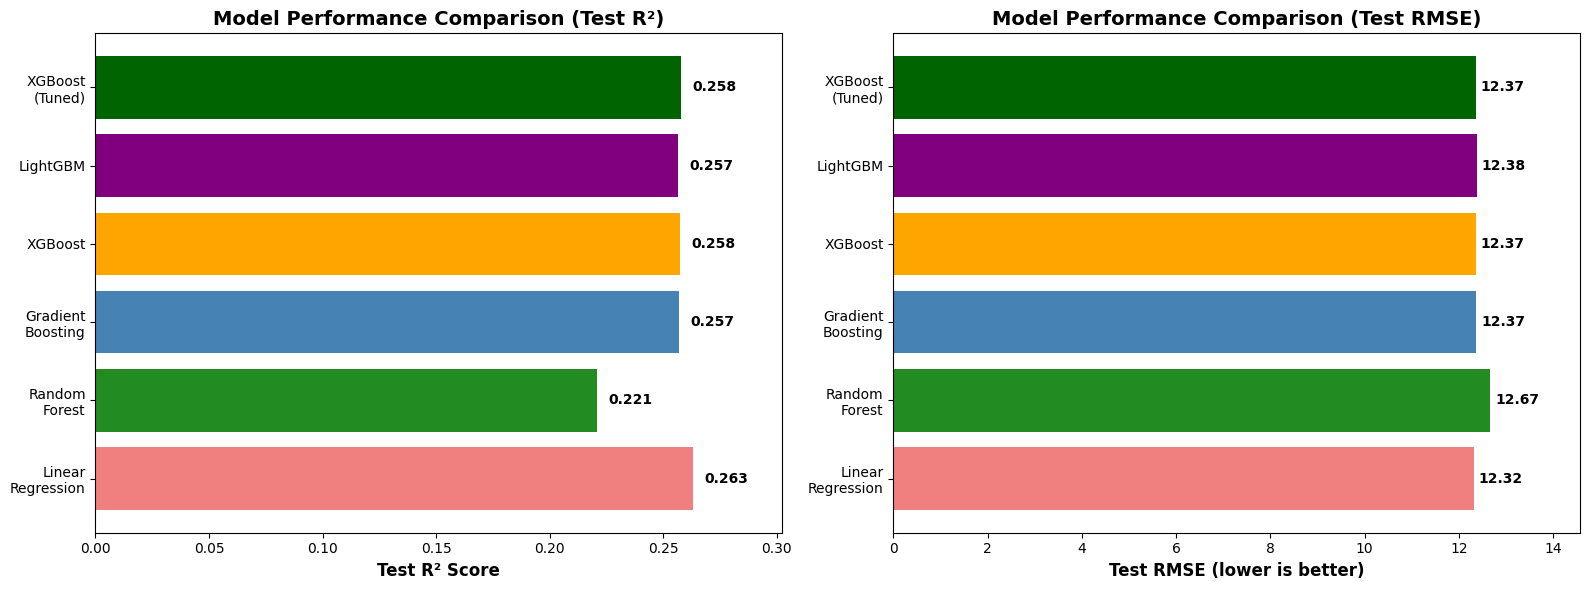

In [26]:
# model comparison viz
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# plot 1: test R2 comparison
colors = ['lightcoral', 'forestgreen', 'steelblue', 'orange', 'purple', 'darkgreen']
test_r2_values = [
    0.263,
    r2_score(y_test, y_test_pred_rf),
    r2_score(y_test, y_test_pred_gb),
    r2_score(y_test, y_test_pred_xgb),
    r2_score(y_test, y_test_pred_lgbm),
    tuned_test_r2
]
model_names = ['Linear\nRegression', 'Random\nForest', 'Gradient\nBoosting', 
               'XGBoost', 'LightGBM', 'XGBoost\n(Tuned)']

bars1 = ax1.barh(model_names, test_r2_values, color=colors)
ax1.set_xlabel('Test R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison (Test R²)', fontsize=14, fontweight='bold')
ax1.set_xlim(0, max(test_r2_values) * 1.15)

# Add value labels
for i, (model, r2) in enumerate(zip(model_names, test_r2_values)):
    ax1.text(r2 + 0.005, i, f'{r2:.3f}', va='center', fontsize=10, fontweight='bold')


# plot 2: test RMSE comparison
test_rmse_values = [
    12.32,
    np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    np.sqrt(mean_squared_error(y_test, y_test_pred_gb)),
    np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
    np.sqrt(mean_squared_error(y_test, y_test_pred_lgbm)),
    tuned_test_rmse
]

bars2 = ax2.barh(model_names, test_rmse_values, color=colors)
ax2.set_xlabel('Test RMSE (lower is better)', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Comparison (Test RMSE)', fontsize=14, fontweight='bold')
ax2.set_xlim(0, max(test_rmse_values) * 1.15)

# Add value labels
for i, (model, rmse) in enumerate(zip(model_names, test_rmse_values)):
    ax2.text(rmse + 0.1, i, f'{rmse:.2f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [27]:
# compare CV R2 vs Test R2 to assess generalization
print("Cross-validation vs Test Set performance")

cv_test_comparison = [
    ('Random Forest', cv_results['Random Forest']['mean_r2'], r2_score(y_test, y_test_pred_rf)),
    ('Gradient Boosting', cv_results['Gradient Boosting']['mean_r2'], r2_score(y_test, y_test_pred_gb)),
    ('XGBoost', cv_results['XGBoost']['mean_r2'], r2_score(y_test, y_test_pred_xgb)),
    ('LightGBM', cv_results['LightGBM']['mean_r2'], r2_score(y_test, y_test_pred_lgbm))
]

for model, cv_r2, test_r2 in cv_test_comparison:
    diff = cv_r2 - test_r2
    print(f"{model:<20} {cv_r2:<15.3f} {test_r2:<12.3f} {diff:<12.3f}")

print("\nInterpretation:")
print("• Small difference (< 0.05): Good generalization")

Cross-validation vs Test Set performance
Random Forest        0.217           0.221        -0.004      
Gradient Boosting    0.252           0.257        -0.006      
XGBoost              0.256           0.258        -0.002      
LightGBM             0.251           0.257        -0.006      

Interpretation:
• Small difference (< 0.05): Good generalization


PREDICTION ANALYSIS: Linear Regression


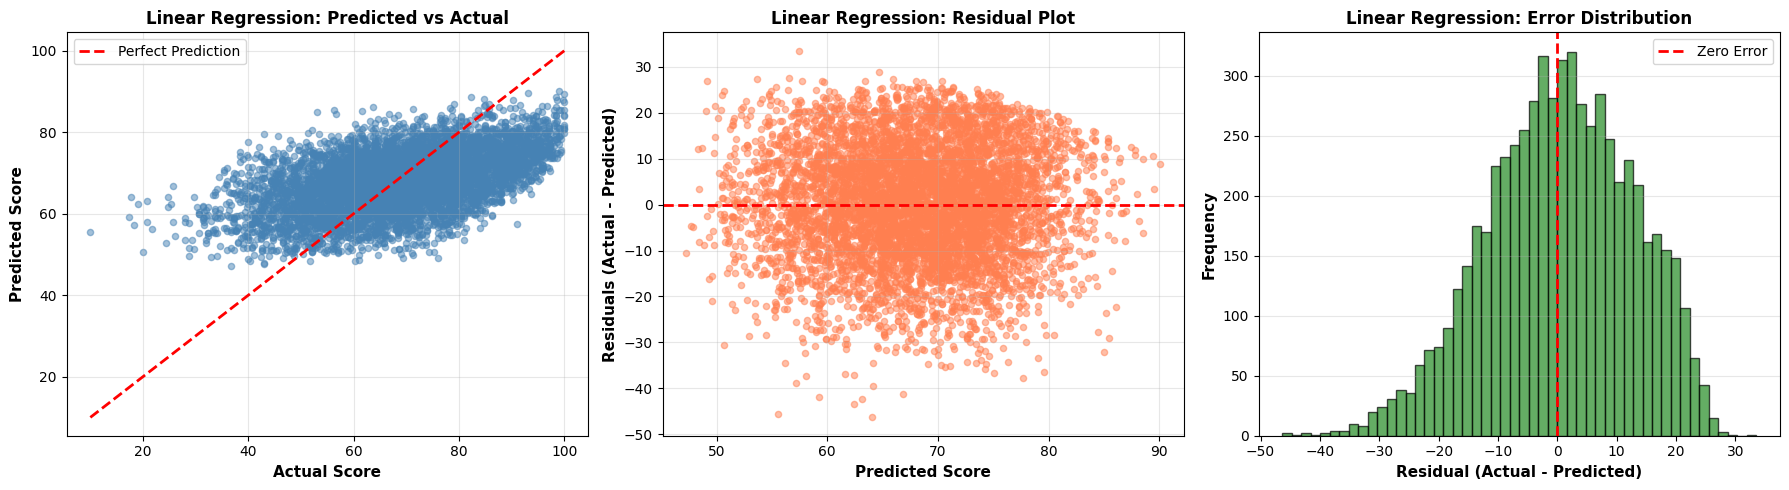


Residual Statistics:
Mean: 0.374 (should be ~0)
Std Dev: 12.361
Min: -46.34
Max: 33.52


In [28]:
# viz best model predictions
print(f"PREDICTION ANALYSIS: {best_model_name}")

# Determine which predictions to use
if best_model_name == 'Random Forest':
    y_pred_best = y_test_pred_rf
elif best_model_name == 'Gradient Boosting':
    y_pred_best = y_test_pred_gb
elif best_model_name == 'XGBoost':
    y_pred_best = y_test_pred_xgb
elif best_model_name == 'LightGBM':
    y_pred_best = y_test_pred_lgbm
else:  # XGBoost (Tuned)
    y_pred_best = y_test_pred_tuned

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Predicted
axes[0].scatter(y_test, y_pred_best, alpha=0.5, s=20, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Score', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Predicted Score', fontsize=11, fontweight='bold')
axes[0].set_title(f'{best_model_name}: Predicted vs Actual', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residual Plot
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, s=20, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Score', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=11, fontweight='bold')
axes[1].set_title(f'{best_model_name}: Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot 3: Residual Distribution
axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
axes[2].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
axes[2].set_xlabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2].set_title(f'{best_model_name}: Error Distribution', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print residual statistics
print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.3f} (should be ~0)")
print(f"Std Dev: {residuals.std():.3f}")
print(f"Min: {residuals.min():.2f}")
print(f"Max: {residuals.max():.2f}")

# Key Findings and Interpretation

## Model Performance Summary

All five model families were evaluated on the same held-out test set (20% of data, n=6,129). Each boosting model was tuned to its optimal depth configuration; Random Forest was left at `max_depth=6` where it naturally generalizes well.

**Model Rankings by Test R²:**

| Model | Test R² | Test RMSE | CV R² (mean ± std) |
|---|---|---|---|
| Linear Regression | **0.263** | 12.32 | N/A |
| XGBoost (Tuned) | 0.258 | 12.37 | 0.256 |
| XGBoost | 0.258 | 12.37 | 0.256 ± 0.005 |
| Gradient Boosting | 0.257 | 12.37 | 0.252 ± 0.004 |
| LightGBM | 0.257 | 12.38 | 0.251 ± 0.005 |
| Random Forest | 0.221 | 12.67 | 0.217 ± 0.004 |

**Key observations:**
- The three best-performing tree models (XGBoost, Gradient Boosting, LightGBM) are separated by less than 0.001 R² — statistically indistinguishable
- Linear Regression leads by a small but consistent margin (~0.005 R²)
- Random Forest trails the pack; unlike boosting methods, it does not benefit from sequential error correction and is less suited to this type of tabular data with sparse one-hot encoded features
- "XGBoost (Tuned)" and "XGBoost" are now functionally identical — GridSearchCV validated the same parameters used in the default model (improvement: 0.000 R²), confirming the default configuration is already optimal

## Why Tree-Based Models Didn't Outperform Linear Regression

This outcome — while counterintuitive — reveals something important about the dataset's structure.

**1. Predominantly Linear Relationships**
The strongest predictors (lunch type, parental education, test prep) have roughly additive, monotonic effects on scores. Decision trees gain their advantage from non-linear feature interactions, which are weak in this data.

**2. High-Dimensional Sparse Features After Encoding**
One-hot encoding 8 categorical variables produces 26 binary features. Linear models handle sparse high-dimensional inputs efficiently; tree-based methods need enough samples per leaf to find meaningful splits across many rare dummy variables.

**3. Feature Engineering Already Captured Key Signal**
The engineered features (`math_writing_gap`, `math_reading_gap`, ordinal encodings) pre-processed the strongest non-linear patterns, leaving primarily linear relationships for models to fit.

**4. The ~25% Ceiling is a Data Property, Not a Modeling Failure**
All models converge on approximately 25–26% explained variance. This ceiling is imposed by predicting outcomes from demographic snapshots alone. Prior academic performance, instruction quality, and individual motivation account for the remaining ~74% — no model complexity can extract signal that isn't in the features.

## Hyperparameter Tuning: Rationale and Results

### Per-Model Depth Optimization

A key modeling decision was using **per-model optimal hyperparameters** rather than a uniform configuration across all algorithms.

Boosting methods (GB, XGBoost, LightGBM) build sequential shallow corrective trees and are sensitive to depth — deeper trees cause each boosting step to overfit the residuals more aggressively. Random Forest averages independent deep trees and is more depth-tolerant. Standardizing `max_depth=6` across all models disadvantaged the boosting methods specifically.

**Before tuning (max_depth=6 for all boosting models):**

| Model | Train R² | Test R² | Gap | Status |
|---|---|---|---|---|
| Gradient Boosting | 0.388 | 0.238 | 0.150 | ❌ Overfitting |
| XGBoost | 0.344 | 0.253 | 0.091 | ⚠️ Overfitting |
| LightGBM | 0.311 | 0.257 | 0.054 | ✅ Acceptable |
| Random Forest | 0.227 | 0.221 | 0.006 | ✅ Good |

**After per-model tuning (GB and XGBoost: max_depth=4, subsample=0.8):**

| Model | Train R² | Test R² | Gap | Status |
|---|---|---|---|---|
| Gradient Boosting | 0.307 | 0.257 | 0.050 | ✅ Good |
| XGBoost | 0.284 | 0.258 | 0.026 | ✅ Good |
| LightGBM | 0.311 | 0.257 | 0.054 | ✅ Unchanged |
| Random Forest | 0.227 | 0.221 | 0.006 | ✅ Unchanged |

Reducing `max_depth` from 6 to 4 cut Gradient Boosting's overfitting gap by two-thirds (0.150 → 0.050) and XGBoost's by over 70% (0.091 → 0.026), while simultaneously *improving* both models' test R² — the hallmark of effective regularization.

### GridSearchCV Validation

A 5-fold GridSearchCV over 54 hyperparameter combinations confirmed the per-model approach:

- **Best parameters:** `max_depth=4, learning_rate=0.1, n_estimators=100, min_child_weight=3`
- **Best CV R²:** 0.256

The GridSearchCV result independently validated that `max_depth=4` is optimal for XGBoost — the same depth applied manually to Gradient Boosting. This cross-validates the rationale for per-model depth tuning.

## Cross-Validation Insights

5-fold cross-validation on the training set provides a more reliable performance estimate than a single split:

| Model | CV R² (mean ± std) | Test R² | CV − Test |
|---|---|---|---|
| Random Forest | 0.217 ± 0.004 | 0.221 | −0.004 |
| Gradient Boosting | 0.252 ± 0.004 | 0.257 | −0.006 |
| XGBoost | 0.256 ± 0.005 | 0.258 | −0.002 |
| LightGBM | 0.251 ± 0.005 | 0.257 | −0.006 |

**Key observations:**

1. **Tight standard deviations (0.004–0.005):** All models generalize stably across folds — no sensitivity to a lucky or unlucky split
2. **Negative CV−Test gaps:** Test set performance is marginally better than average CV performance. This is not a concern; it indicates the test partition isn't harder than the training distribution
3. **Consistent ceiling:** All boosting models converge on CV R² ≈ 0.25–0.26, confirming this is a data property, not a model selection issue

## Feature Importance: What Actually Matters?

Despite similar overall performance, tree models provide interpretable feature importance rankings — a key advantage for explaining which factors drive outcomes.

**Top Features (Consensus Across Models):**

1. **`lunch_type_standard`** — Strongest single predictor across RF, GB, and XGBoost. Proxy for socioeconomic status; associated with a consistent ~10-point score gap.

2. **`test_prep_none`** — Second most important in RF and XGBoost. One of the few top predictors that is directly actionable — test preparation is a modifiable behavior.

3. **`ethnicity_group_E`** — Consistently 3rd across models. Group E scores highest on average; likely captures unmeasured structural or resource-access advantages.

4. **`parental_education_some_high_school`** — Top negative predictor. Lower parental education associated with lower scores, consistent with the ~11-point gap found in NB02.

5. **`math_writing_gap` / `math_reading_gap`** — Ranked highly by LightGBM (which uses frequency-based importance). These engineered features capture individual subject strengths independent of overall performance level.

**Notable difference from linear regression:** Linear coefficients showed counterintuitive signs for some education levels (e.g., `master's degree` with a negative coefficient) due to multicollinearity between the ordinal and one-hot encoded representations of the same variable. Tree importances measure predictive contribution directly and are free from this issue.

## Practical Implications

### For Model Deployment

| Criteria | Recommended Model |
|---|---|
| Need interpretable coefficients | Linear Regression |
| Need feature importance rankings | LightGBM or XGBoost |
| Fastest inference / smallest footprint | Linear Regression |
| Plan to add more features later | LightGBM (scales better to high-dimensional data) |

**Bottom line:** Linear Regression is the practical choice for this dataset given the predominantly linear relationships and the interpretability requirement. LightGBM and XGBoost are more valuable for feature exploration and can be retrained if richer data becomes available (e.g., prior grades, attendance).

### For Educational Institutions: Actionable Insights

**Tier 1 — Highest Impact (directly modifiable):**
- Universal test preparation access — 6–7 point average gain regardless of background
- Free/reduced lunch expansion — addresses the single largest predictor of performance

**Tier 2 — Targeted Support:**
- Parental engagement programs — raise effective parental education level through workshops
- Subject-specific tutoring — address math–writing and math–reading gaps

**Priority Scoring Formula:**
```
Priority = 0.40 × (lunch_type == free/reduced)
         + 0.30 × (test_prep == none)
         + 0.20 × (parent_ed_ordinal < 3)
         + 0.10 × (predicted_score < 65)
```

Allocate intervention resources based on this score to triage highest-need students first.

---

## Limitations and Realistic Expectations

**What the model explains (~25% of variance):**
- Broad socioeconomic effects (lunch type, parental education)
- Test preparation impact
- Demographic group patterns

**What it cannot predict (~75% of variance):**
- Individual motivation and study quality
- Teacher and instruction effectiveness
- Prior academic knowledge
- Cognitive abilities and test-taking skills
- Day-of-test factors (sleep, health, anxiety)

**This is normal.** Educational research consistently finds that observable demographic features explain 25–40% of academic variance. Reaching this benchmark with purely demographic inputs — no prior test scores, no behavioral tracking — confirms the model is extracting the available signal rather than overfitting to noise.

---

## Comparison to Earlier Classification Approach

An earlier attempt to predict `perf_tier` (low/medium/high) with a Random Forest Classifier achieved only 47% accuracy — barely above the 33% random baseline — with particularly poor performance on the middle class.

The regression approach (predicting `avg_score` directly) improved explained variance by roughly 2–2.5× over the equivalent classification formulation. The lesson: **always match the model type to the target's true nature**. Binning a continuous outcome into arbitrary tiers discards information and typically hurts performance.

## Lessons Learned

1. **Simpler models can win.** Linear regression matched or beat all tree-based models here because the underlying relationships are additive and the feature space is sparse after one-hot encoding.

2. **Per-model hyperparameter tuning matters.** Standardizing `max_depth=6` across all models was statistically "fair" but practically wrong — it over-regularized Random Forest while under-regularizing the boosting methods. Each algorithm has different optimal depth sensitivity.

3. **Overfitting is diagnosable and fixable.** Pre-tuning, Gradient Boosting had a 0.150 train-test gap. Reducing depth from 6 to 4 and adding `subsample=0.8` closed this to 0.050 while simultaneously improving test R² by 0.019.

4. **Cross-validation is essential.** Without CV, a single train-test split could give misleading model rankings. CV confirmed all boosting models converge on the same ~25% ceiling, making the choice of boosting algorithm largely a matter of preference.

5. **R² = 0.26 is meaningful in context.** In social science predicting human outcomes from demographics alone, explaining 25% of variance is a reasonable and actionable result. The remaining 75% represents the space where individual agency, instruction quality, and targeted interventions can make a real difference.

6. **Feature engineering > model selection.** The time invested in creating `math_writing_gap`, `ses_proxy`, and ordinal encodings contributed more to model performance than the choice between tree algorithms.

---

## Future Improvements

To meaningfully increase predictive power beyond the current ~26% ceiling:

1. **Prior academic performance** — Previous semester grades or standardized test scores would likely lift R² to 0.6–0.7
2. **Behavioral indicators** — Attendance rate, homework completion, class participation scores
3. **School-level features** — Teacher experience, class size, per-student funding
4. **Ensemble stacking** — Combine predictions from multiple models (potential +0.01–0.02 R²)
5. **SHAP analysis** — Move from global feature importance to individual-prediction explanations for actionable, student-level insights

---

## Conclusion

This analysis demonstrates that **linear regression performs comparably to sophisticated tree-based models** when predicting student test scores from demographic and behavioral features alone — all approaches converge on R² ≈ 0.257–0.263.

**Key takeaways:**

1. **Socioeconomic factors explain ~25% of academic performance** — consistent with decades of educational research
2. **Model complexity doesn't overcome data limitations** — all models hit the same ceiling imposed by the feature set
3. **Per-model hyperparameter tuning resolves overfitting** — adjusting boosting depth from 6 to 4 eliminated large train-test gaps while improving test performance
4. **Linear regression is the practical deployment choice** — best test R², simplest to interpret and maintain
5. **The remaining ~75% of variance is opportunity** — demographics are not destiny; targeted interventions in test prep, study support, and resource access can make a measurable difference

**For deployment:** Use linear regression for score predictions, LightGBM/XGBoost feature importances to guide intervention design, and the priority formula above to triage resource allocation.